## CV02 - ablation study

논문이 간단하게 구현할 수 있도록 코드나 제공을 제공하기도 한다.   
논문 내에 아이디어를 증명하는 방법은 아이디어를 적용하지 않은 방법과 적용한 방법을 비교한다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


딥러닝 용어 정리, Normalization   
https://light-tree.tistory.com/132   

In [6]:
# 입력값은 normalization해 주는 게 좋다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# CIFAR-10 데이터셋은 10개의 클래스가 있다.
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

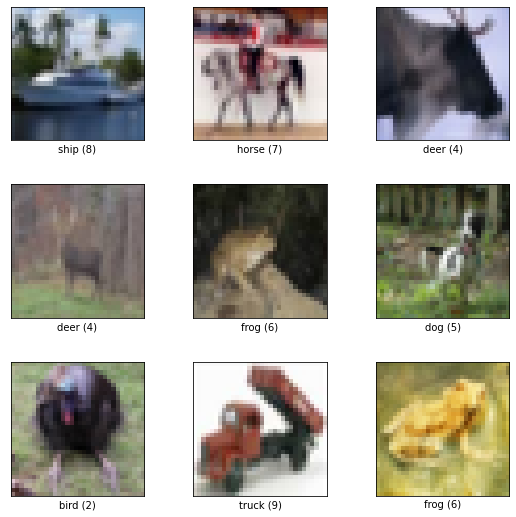

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

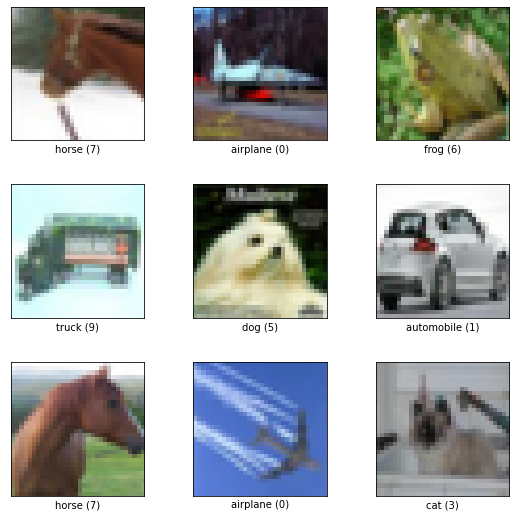

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

모델을 구현하는 과정에서 반복되는 부분이나, 조정할 수 있는 하이퍼파라미터나 변수를 쉽게 변경할 수 있도록   
모듈화 시켜서 '블록' 단위로 만드는 게 좋다.   
ResNet-18, 34, 50, 101, 152 다섯 개의 네트워크가 있다.   
실험 시 하나씩 할 수도 있지만 블록화 시켜서 기본 단위로 만들어 주면 조금만 수정해서 전체 실험을 실행 할 수 있다.   
우선 VGG로 기본 블록 만들어 보자.   
VGG 블록은 여러 개의 CNN 레이어와 한 개의 Max pooling 레이어로 구성.
CNN 레이어는 모두 3x3크기의 커널을 가지고 있다.
블록은 여러 개일 수 있으며 그 안의 CNN 레이어 갯수도 다를 수 있으며 블록간 채널 수도 다를 수 있다.   
블록 내에 레이어 수와 채널를 조절할 수 있어야 한다.   

In [13]:
# function for building VGG Block

# block_num: 블록 number 지정
# 
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [15]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 블록을 조합하여 VGG-16 모델 만들기

# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [17]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [18]:
# VGG-19 모델 만들기

# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [23]:
# VGG-16과 VGG-19 모델의 성능 비교
BATCH_SIZE = 256
EPOCH = 40

In [24]:
# CIFAR-10 데이터셋 불러오기

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [25]:
# 40Epoch권장

vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 41s 212ms/step - loss: 2.1762 - accuracy: 0.1945 - val_loss: 2.0747 - val_accuracy: 0.2523
Epoch 2/40
195/195 [==============================] - 16s 85ms/step - loss: 1.9819 - accuracy: 0.2831 - val_loss: 1.8999 - val_accuracy: 0.3229
Epoch 3/40
195/195 [==============================] - 17s 85ms/step - loss: 1.8557 - accuracy: 0.3318 - val_loss: 1.7657 - val_accuracy: 0.3510
Epoch 4/40
195/195 [==============================] - 17s 85ms/step - loss: 1.7484 - accuracy: 0.3720 - val_loss: 1.6882 - val_accuracy: 0.3955
Epoch 5/40
195/195 [==============================] - 17s 85ms/step - loss: 1.6706 - accuracy: 0.4001 - val_loss: 1.6590 - val_accuracy: 0.4091
Epoch 6/40
195/195 [==============================] - 17s 86ms/step - loss: 1.6051 - accuracy: 0.4222 - val_loss: 1.5766 - val_accuracy: 0.4426
Epoch 7/40
195/195 [==============================] - 17s 86ms/step - loss: 1.5528 - accuracy: 0.4442 - val_loss: 1.5823 - val_accuracy

In [26]:
# VGG-19 모델 훈련하기

vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 19s 99ms/step - loss: 2.2102 - accuracy: 0.1781 - val_loss: 2.1077 - val_accuracy: 0.2304
Epoch 2/40
195/195 [==============================] - 20s 100ms/step - loss: 2.0238 - accuracy: 0.2623 - val_loss: 1.9551 - val_accuracy: 0.2945
Epoch 3/40
195/195 [==============================] - 19s 100ms/step - loss: 1.8894 - accuracy: 0.3141 - val_loss: 1.8157 - val_accuracy: 0.3308
Epoch 4/40
195/195 [==============================] - 20s 101ms/step - loss: 1.7752 - accuracy: 0.3568 - val_loss: 1.7112 - val_accuracy: 0.3810
Epoch 5/40
195/195 [==============================] - 20s 100ms/step - loss: 1.6812 - accuracy: 0.3942 - val_loss: 1.6158 - val_accuracy: 0.4197
Epoch 6/40
195/195 [==============================] - 20s 101ms/step - loss: 1.6223 - accuracy: 0.4123 - val_loss: 1.6074 - val_accuracy: 0.4295
Epoch 7/40
195/195 [==============================] - 20s 101ms/step - loss: 1.5657 - accuracy: 0.4364 - val_loss: 1.5142 - val_acc

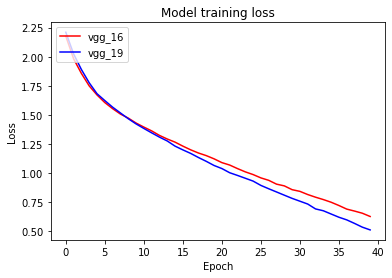

In [28]:
# 그래프로 시각화하여 비교하기
# 훈련손실

import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

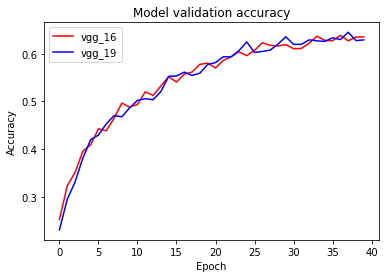

In [29]:
# 검증 정확도(validation accuracy)

plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()